In [1]:
import os
import math
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
#Import datasets
global_dir_path = "C://Users/chris/OneDrive/Desktop/MIT postdoc project/ABN project/Lung cancer/Headspace_data"
dir_path0 = global_dir_path + '/2024_0626_Breath_EA_6w'
dir_path1 = global_dir_path + '/2024_1025_Breath_EA_6w'

In [3]:
dict_name = {}
dict_name["name0"] = dir_path0 + '/Zscore_AUC_6w_062624.xlsx'
dict_name["name1"] = dir_path1 + '/Zscore_AUC_6w_102524.xlsx'

dict_df = {}
for i in range(0, len(dict_name)):
    dict_df["df"+ str(i)] = pd.read_excel(dict_name["name" + str(i)])
    
df_all = pd.concat([dict_df["df0"], dict_df["df1"]], axis=0, ignore_index=True)

In [4]:
def pca_analysis(df):
    ns_pca = df.iloc[:,1:6]
    pca_cancer = PCA(n_components = 2)
    components_cancer = pca_cancer.fit_transform(ns_pca)
    pca_result = pd.DataFrame(data = components_cancer, columns = ['PCA1', 'PCA2'])
    
    return pca_cancer, pca_result

In [5]:
def astype(df):
    pca_result = pca_analysis(df)[1]
    
    type = df.iloc[:,0]
    
    assign_type = []
    for i in type:
        if 'H' in i:
            assign_type.append('Healthy')
        elif 'E' in i:
            assign_type.append('Cancer')
        else:
            assign_type.append('Treated')

    pca_result['Label'] = assign_type
    
    return pca_result

In [6]:
def PC1_PC2(df):
    pca_cancer = pca_analysis(df)[0]
    
    result = pca_cancer.explained_variance_ratio_
    PC1_result = round(result[0], 2)*100
    PC2_result = round(result[1], 2)*100
    
    return PC1_result, PC2_result

In [7]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

In [8]:
def confidence_ellipse_new(x, y, ax, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    
    cov = np.cov(x,y)
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    w, h = 1.96 * 2 * np.sqrt(vals) #95% confidence
    
    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)),width=w, height=h,
      angle=theta, facecolor=facecolor, alpha=1.0, **kwargs)

    return ax.add_patch(ellipse)

#ref: https://rayblick.gitbooks.io/my-python-scrapbook/content/analysis/plotting/scatterplot_ellipse.html
#ref: https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipse-in-a-scatterplot-using-matplotlib

In [9]:
def ell_values(df):
    pca_result = astype(df) #result in pca_result

    ell_E_x = []
    ell_E_y = []
    ell_H_x = []
    ell_H_y = []
    ell_T_x = []
    ell_T_y = []

    for i in range(0, len(pca_result)):
        if pca_result['Label'].iloc[i] == 'Healthy':
            ell_H_x.append(pca_result['PCA1'].iloc[i])
            ell_H_y.append(pca_result['PCA2'].iloc[i])
        elif pca_result['Label'].iloc[i] == 'Cancer':
            ell_E_x.append(pca_result['PCA1'].iloc[i])
            ell_E_y.append(pca_result['PCA2'].iloc[i])
        elif pca_result['Label'].iloc[i] == 'Treated':
            ell_T_x.append(pca_result['PCA1'].iloc[i])
            ell_T_y.append(pca_result['PCA2'].iloc[i])

    ell_E_x = np.array(ell_E_x)
    ell_E_y = np.array(ell_E_y)
    ell_H_x = np.array(ell_H_x)
    ell_H_y = np.array(ell_H_y)
    ell_T_x = np.array(ell_T_x)
    ell_T_y = np.array(ell_T_y)
                       
    return ell_H_x, ell_H_y, ell_E_x, ell_E_y, ell_T_x, ell_T_y

In [10]:
def plot_figure(df):
    pca_result = astype(df)
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.rc('font', family='Arial')
    
    confidence_ellipse_new(ell_values(df)[0], ell_values(df)[1], ax, edgecolor = 'black')
    confidence_ellipse_new(ell_values(df)[2], ell_values(df)[3], ax, edgecolor = 'red')
    confidence_ellipse_new(ell_values(df)[4], ell_values(df)[5], ax, edgecolor = 'blue')

    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.xlabel('PC1 ({}% explained var.)'.format(round(PC1_PC2(df)[0],2)), fontsize=18, fontname="Arial")
    plt.ylabel('PC2 ({}% explained var.)'.format(round(PC1_PC2(df)[1],2)), fontsize=18, fontname="Arial")

    targets = ['Healthy', 'Cancer', 'Treated']
    colors = ['black','red', 'blue']

    for target, color in zip(targets,colors):
        indices = pca_result['Label'] == target
        
        plt.scatter(pca_result.loc[indices, 'PCA1'], pca_result.loc[indices, 'PCA2'], c = color, s = 45)

#     plt.legend(targets, prop={'size':12}, edgecolor="None", loc="upper right")

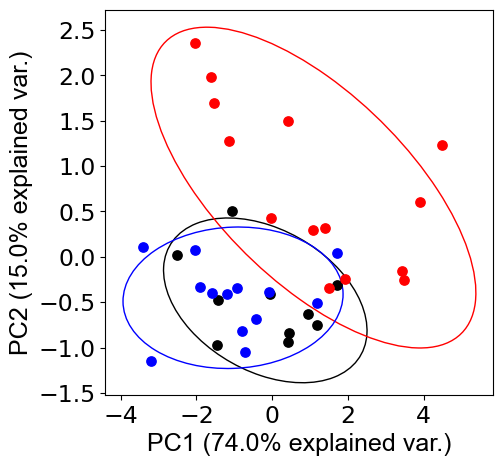

In [11]:
plot_figure(df_all)